# Decision Trees

## Setup

In [1]:
# Install required packages
# Uncomment the following lines to install the necessary packages if not already installed
# !pip install numpy
# !pip install pandas
# !pip install scikit-learn
# !pip install matplotlib

In [2]:
# Import necessary libraries
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

# What is %matplotlib inline?
# %matplotlib inline is a magic command in Jupyter notebooks that allows for the display of matplotlib plots inline within the notebook.
# What is a magic command?
# Magic commands are special commands in Jupyter notebooks that start with a % or %% and provide additional functionality to the notebook environment.
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Accessing the data

In [3]:
# Set path to the dataset
path = '..\_program resources\drug200.csv'

# Assign the path to a dataframe 
df = pd.read_csv(path)

# Display the head and tail of the dataframe
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


## Reviewing the data

In [4]:
# Explore the dataset information
# Note that in Dtype, 4 columns (sex, bp, cholesterol, and drug) are the object type
# They are categorical variables that need to be converted to numerical values to be used in the model
# The 'Drug' column is the target variable, so we will not convert it to numerical values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


## Preprocessing

In [5]:
label_encoder = LabelEncoder()

# Convert 3 of the 4 categorical variables to numerical values
df['Sex'] = label_encoder.fit_transform(df['Sex']) # for Sex, female is 0, male is 1
df['BP'] = label_encoder.fit_transform(df['BP']) # for BP, high is 0, low is 1, normal is 2 
df['Cholesterol'] = label_encoder.fit_transform(df['Cholesterol']) # for Cholesterol, high is 0, normal is 1

# The 'Drug' column is the target variable, which will not be converted to numerical values, uncomment the following line if changing the target variable
# df['Drug'] = label_encoder.fit_transform(df['Drug'])

# Display the head and tail of the dataframe after conversion
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,drugY
1,47,1,1,0,13.093,drugC
2,47,1,1,0,10.114,drugC
3,28,0,2,0,7.798,drugX
4,61,0,1,0,18.043,drugY
...,...,...,...,...,...,...
195,56,0,1,0,11.567,drugC
196,16,1,1,0,12.006,drugC
197,52,1,2,0,9.894,drugX
198,23,1,2,1,14.020,drugX


In [8]:
# Check for missing values in the dataset
df.isnull().sum() # No missing values in the original dataset, but drugNum is missing 23 values

Age             0
Sex             0
BP              0
Cholesterol     0
Na_to_K         0
Drug            0
Drug_num       23
dtype: int64

In [10]:
# Create a custom mapping for the 'Drug' column to convert it to numerical values
custom_map = {'drugA':0,'drugB':1,'drugC':2,'drugX':3,'drugY':4}

# Map the 'Drug' column to numerical values using the custom mapping
df['Drug_num'] = df['Drug'].map(custom_map)

# Display the head and tail of the dataframe after mapping
df # Observe that the 'Drug_num' column is added to the dataframe with numerical values for the 'Drug' column

,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Drug_num
0,23,0,0,0,25.355,drugY,4
1,47,1,1,0,13.093,drugC,2
2,47,1,1,0,10.114,drugC,2
3,28,0,2,0,7.798,drugX,3
4,61,0,1,0,18.043,drugY,4
...,...,...,...,...,...,...,...
195,56,0,1,0,11.567,drugC,2
196,16,1,1,0,12.006,drugC,2
197,52,1,2,0,9.894,drugX,3
198,23,1,2,1,14.020,drugX,3


In [16]:
# Use the corr() method to check the correlation between the features and the target variable
# Use numeric_only=True to ignore non-numeric columns such as instances of 'drugY'
df.corr(numeric_only=True)['Drug_num'].sort_values(ascending=False)

# The correlation values are between -1 and 1 
# -1 indicates a perfect negative correlation 
# 0 indicates no correlation.
# 1 indicates a perfect positive correlation 

# Observe that Drug_num has relatively strong correlation with the features 'Cholesterol' and 'BP'

Drug_num       1.000000
Na_to_K        0.589120
BP             0.372868
Cholesterol    0.055629
Age           -0.004828
Sex           -0.098573
Name: Drug_num, dtype: float64

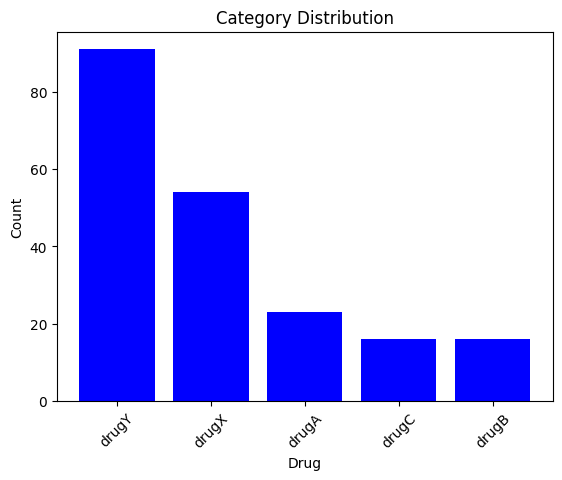

In [18]:
# Display the counts of each category in the 'Drug' column
category_counts = df['Drug'].value_counts()

# Make a count plot
plt.bar(category_counts.index, category_counts.values, color='blue')
plt.xlabel('Drug')
plt.ylabel('Count')
plt.title('Category Distribution')
plt.xticks(rotation=45)
plt.show()

# Observe that drugY and drugX  are the most common categories, while drugB is the least common category

## Modeling

In [25]:
# Separate the features and target variable
# The target variable is 'Drug', and the features are all other columns except 'Drug' and 'Drug_num'
y = df['Drug'] # target variable
X = df.drop(['Drug', 'Drug_num'], axis=1) # features; axis=1 to drop columns, axis=0 to drop rows

In [26]:
# Separate the training and testing data with 30% of the data for testing and 70% for training
# The random_state parameter is set to 32 for reproducibility
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=32)

In [27]:
# Define and train the Decision Tree Classifier
# The criterion is set to 'entropy' for information gain (a measure of the reduction in uncertainty about the target variable after observing the feature)
# The max_depth parameter is set to 4 to limit the depth of the tree and prevent overfitting
drugTree = DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [28]:
# Train the model using the training data with fit()
# The fit() method is used to train the decision tree model on the training data
# The first argument is the features (X_trainset) and the second argument is the target variable (y_trainset)
drugTree.fit(X_trainset, y_trainset)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

## Evaluation

In [ ]:
# Generate predictions using the testing data with predict()
tree_predictions = drugTree.predict(X_testset)

# The predict() method is used to make predictions on the testing data (X_testset) using the trained decision tree model

In [30]:
# Check the accuracy of the model using accuracy_score()
# The accuracy_score() function is used to calculate the accuracy of the model by comparing the predicted values (tree_predictions) with the actual values (y_testset)
print("Decision Tree's Accuracy: ", metrics.accuracy_score(y_testset, tree_predictions))

# The accuracy score is a measure of how well the model performed on the testing data
# The accuracy score is the ratio of the number of correct predictions to the total number of predictions made by the model
# Metrics is a module in scikit-learn that provides functions to evaluate the performance of machine learning models
# The accuracy score is a value between 0 and 1, where 1 indicates perfect accuracy and 0 indicates no accuracy

Decision Tree's Accuracy:  0.9833333333333333


## Visualization

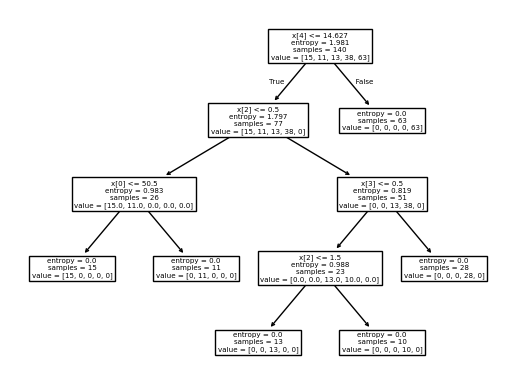

In [31]:
# Generate the tree plot
plot_tree(drugTree)
plt.show()

## Explaining the visualization 

The plot_tree() function is used to visualize the decision tree model

The tree plot shows: 

1) the structure of the decision tree 
2) the features used for splitting 
3) the thresholds for splitting
4) the predicted class labels at each leaf node

The plot_tree() function is a useful tool for understanding how the decision tree model makes predictions based on the input features

Let's break down the syntax:

1) x[0] <= 50.5: This means that the first feature (x[0], Age) is less than or equal to 50.5.
2) entropy: This is the criterion used for splitting the data at this node.
2.1) The entropy is a measure of the impurity or disorder of the data at this node.
2.2) A lower entropy value indicates that the data is more pure or homogeneous, while a higher entropy value indicates that the data is more impure or heterogeneous.
2.3) The entropy is calculated based on the class distribution of the samples at this node.
2.4) The entropy is used to determine the best feature and threshold for splitting the data at this node.
3) samples: 100: This indicates that there are 100 samples (data points) at this node.
4) value: [0, 0, 0, 0, 63]: This indicates the predicted class distribution at this node. In this example, all samples belong to class 4 (drugY).

## Decision Criteria Analysis

Let's remember the features:
- x[0] = Age
- x[1] = Sex
- x[2] = BP
- x[3] = Cholesterol
- x[4] = Na_to_K

At the top of the decision tree, there is x[4] (Na_to_K).

The decision criterion for Drug Y, x[4] is if Na_to_K is greater than 14.627.
> Note: 63 samples for Drug Y in the dataset.

Next, there is a decision node for x[2] (BP), which splits into two decision nodes for x[0] (Age) and x[3] (Cholesterol).
If BP is less than or equal to 0.5, Blood Pressure is considered low or normal.

The decision criterion for Drug C is Na_to_K less than 14.627, BP = Normal, and Cholesterol = High.
> Note: 13 samples for Drug C in the dataset.

If BP is greater than 0.5, then Blood Pressure is considered high. 

The decision criterion for Drug A is Na_to_K less than 14.627, BP = High,  Age is less than 50.5.
> Note: 15 samples for Drug A in the dataset.

The decision criterion for Drug B is Na_to_K less than 14.627, BP = High,  Age is greater than 50.5.
> Note: 11 samples for Drug B in the dataset.

The decision criterion for Drug X is Na_to_K less than 14.627, and two options: 
> Note: 38 samples for Drug X in the dataset.
> 1) BP = Low, Cholesterol = High
> 2) BP = Normal/Low, Cholesterol = Normal

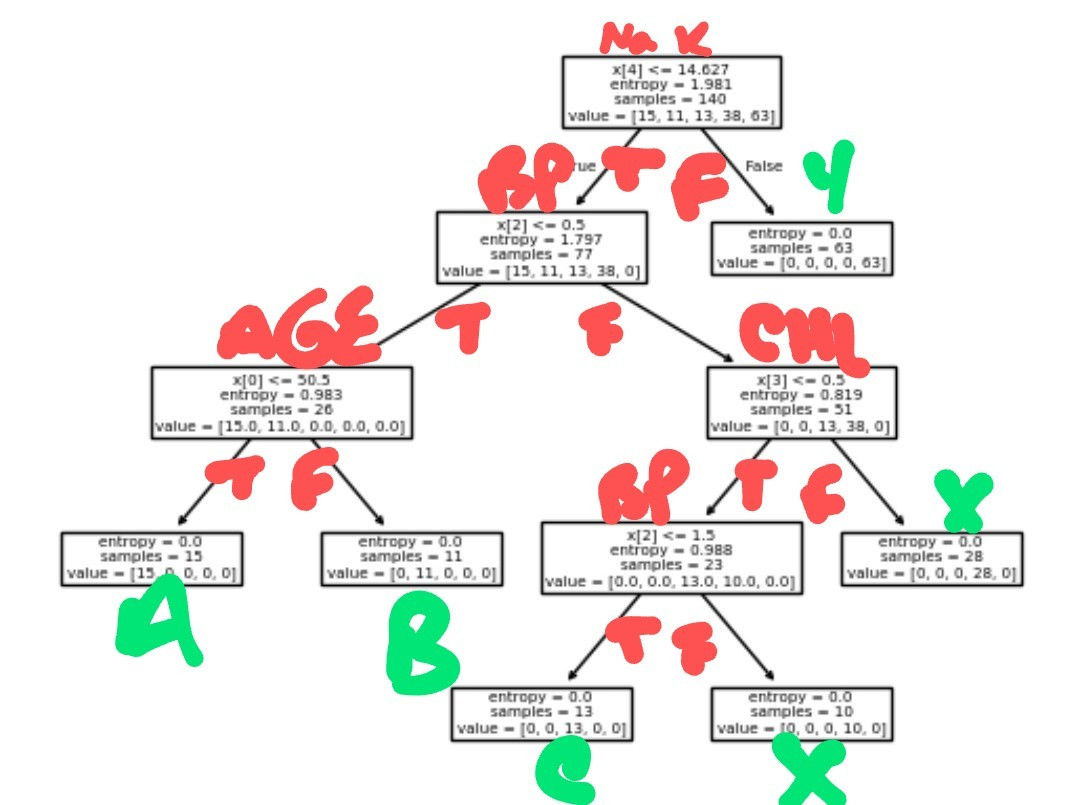

## What if Max Depth of 3 (instead of the original 4)?

Decision Tree's Accuracy:  0.8166666666666667


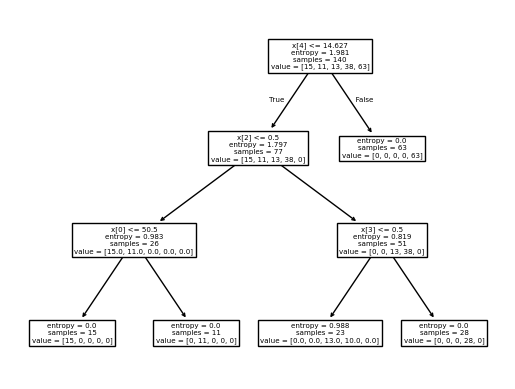

In [32]:
drugTree = DecisionTreeClassifier(criterion='entropy', max_depth=3) # Decrease max_depth to 3
drugTree.fit(X_trainset, y_trainset)
tree_predictions = drugTree.predict(X_testset)
print("Decision Tree's Accuracy: ", metrics.accuracy_score(y_testset, tree_predictions))

plot_tree(drugTree)
plt.show()

If using a Max Depth of 3 instead of the original 4, then the accuracy of the model goes down by about 17%.

## What if 5?

Decision Tree's Accuracy:  0.9833333333333333


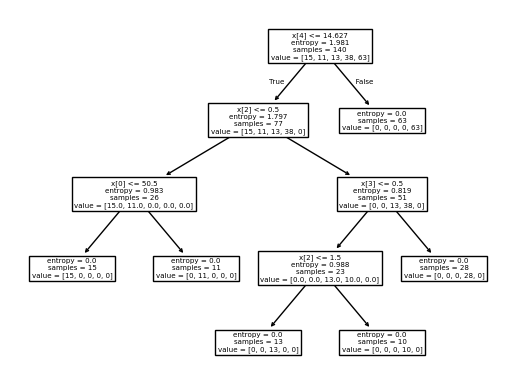

In [36]:
drugTree = DecisionTreeClassifier(criterion='entropy', max_depth=4) # Increase max_depth to 5
drugTree.fit(X_trainset, y_trainset)
tree_predictions = drugTree.predict(X_testset)
print("Decision Tree's Accuracy: ", metrics.accuracy_score(y_testset, tree_predictions))

plot_tree(drugTree)
plt.show()

# Observe that the max_depth of 4 is the best value for this dataset
# Higher max_depth values do not show significant (if any) improvement in accuracy